# DDPG: Pendulum-v0

Vamos treinar um agente DDPG para resolver o problema de equilibrar um pêndulo invertido no ambiente 'Pendulum-v0' do gym.

Neste problema tanto o espaço de estados quanto o espaço de ações são contínuos.
A ação representa o torque aplicado na articulação do pêndulo e o estado é dado por sua posição e velocidade angular.

gym Environment: https://gym.openai.com/envs/Pendulum-v0/

Código em: https://github.com/wau/keras-rl2/blob/master/examples/ddpg_pendulum.py

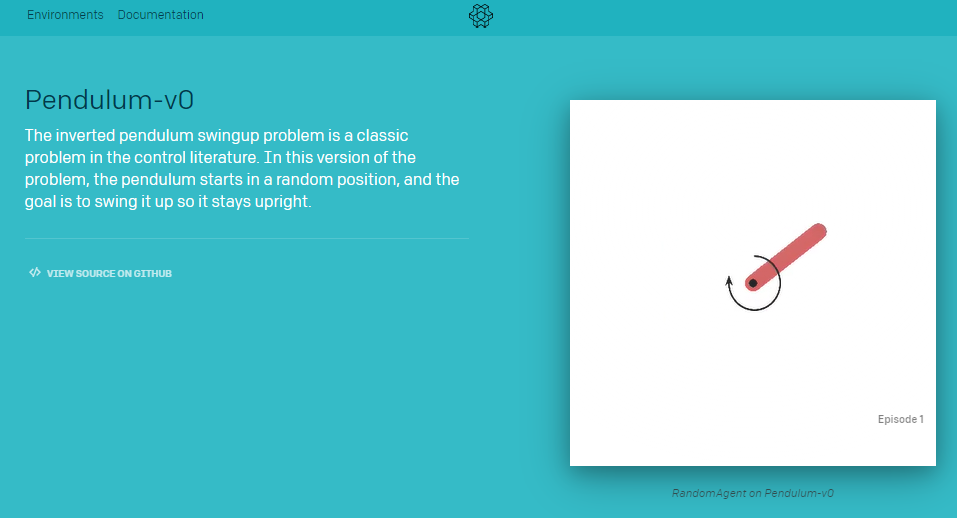

In [ ]:
!pip install keras-rl2

## Imports

In [ ]:
import numpy as np
import gym

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

## Create Environment

In [ ]:
ENV_NAME = 'Pendulum-v0'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

## Create Actor model

In [ ]:
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))
print(actor.summary())

## Create Critic model

In [ ]:
action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

## Create and Compile DDPG Agent

In [ ]:
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

## Train Agent

In [ ]:
agent.fit(env, nb_steps=50000, visualize=True, verbose=1, nb_max_episode_steps=200)

## Save and Test

In [ ]:
# After training is done, we save the final weights.
agent.save_weights(f'ddpg_{ENV_NAME}_weights.h5f', overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
agent.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=200)